In [1]:
from keras.models import load_model,Model
import numpy as np
import keras
from keras.models import Sequential
from keras.datasets import mnist
from matplotlib import pyplot as plt
from keras.layers import Dense,Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization 
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
import math
import keras.backend as Kb
from skimage import transform
import matplotlib.gridspec as gridspec

%matplotlib inline

Using TensorFlow backend.


### Data

### For Mnist

In [2]:
def get_data_mnist():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.reshape(X_train.shape[0],28, 28,1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0],28, 28,1).astype('float32')

    X_train = X_train / 255
    X_test = X_test / 255

    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    num_classes = y_test.shape[1]
    
    return X_train,y_train,X_test,y_test,num_classes

In [3]:
X_train,y_train,X_test,y_test,num_classes = get_data_mnist()

### For line dataset - 96 class

In [4]:
data = np.load('outfile.npz')
X_train=data["X_train.npy"]
X_test=data["X_test.npy"]
y_train=data["y_train.npy"]
y_test=data["y_test.npy"]

In [5]:
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0],28, 28,3).astype('float32')
X_test = X_test.reshape(X_test.shape[0],28, 28,3).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

### For line dataset Q2

In [49]:
# line_dataset is pre-shuffled
f = np.load('As2Q2/outfile.npz')
print(f.files)

['AllImg', 'LenLabel', 'WidLabel', 'ColLabel', 'AngLabel']


In [50]:
train = int(.8 * f['AllImg'].shape[0])
validate = int(.9 * f['AllImg'].shape[0])
test = int(f['AllImg'].shape[0])
print(train, validate-train, test-validate)

76800 9600 9600


In [51]:
# Splitting data
x_train = f['AllImg'][:train]
x_validate = f['AllImg'][train:validate]
x_test = f['AllImg'][validate:test]

y_length_train = f['LenLabel'][:train].argmax(axis=1)
y_length_validate = f['LenLabel'][train:validate].argmax(axis=1)
y_length_test = f['LenLabel'][validate:test].argmax(axis=1)

y_width_train = f['WidLabel'][:train].argmax(axis=1)
y_width_validate = f['WidLabel'][train:validate].argmax(axis=1)
y_width_test = f['WidLabel'][validate:test].argmax(axis=1)

y_colour_train = f['ColLabel'][:train].argmax(axis=1)
y_colour_validate = f['ColLabel'][train:validate].argmax(axis=1)
y_colour_test = f['ColLabel'][validate:test].argmax(axis=1)

y_angle_train = f['AngLabel'][:train]
y_angle_validate = f['AngLabel'][train:validate]
y_angle_test = f['AngLabel'][validate:test]

#### For model - 

In [6]:
# model = load_model('model_mnist/my_model.h5')
#model = load_model('model_mnist/basic.h5')
# model = load_model('model_mnist/my_model.h5')
#model = load_model('model_line/init_model_line.h5')
model = load_model('model_line/deep_L2_line.h5')

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)         73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 6, 128)         512       
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
__________

## Visualize Intermediate layer activations

In [8]:
def activation(model,img,img_lenth,img_width,channels):
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img.reshape(1,img_lenth,img_width,channels))

    return activations

In [9]:
def display_activations(activations,no_activations, act_index): 
    activation = activations[act_index]
    activation_index=0
    
    r = int(math.sqrt(no_activations))+1
    c = int(math.sqrt(no_activations))+1
    
    fig, ax = plt.subplots(r,c,figsize=(r*2.5,c*1.5),gridspec_kw = {'wspace':0, 'hspace':0.2})
    
    row = 0
    col = 0
    while activation_index<no_activations:
        #print(activation.shape)
        ax[row][col].imshow(activation[0, :, :, activation_index], cmap='Oranges_r')
        #ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
        activation_index+=1
        col+=1
        if col==c:
            row+=1
            col=0
    
    
    for i in range(row,r):
        if i!=row:
            col=0
        for j in range(col,c):
            fig.delaxes(ax[i][j])
    
    
    #fig.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(path+"/activation"+str(act_index)+".png")

### Visualizing Convnet Filters 

In [4]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [5]:
def filter_image_gen(layer_name, fi_index, size,channels):
    
    ##fi_index is the filter index at a layer output
    layer_output = model.get_layer(layer_name).output
    #print(layer_output)
    
    loss = Kb.mean(layer_output[:, :, :, fi_index])
    
    gradient = Kb.gradients(loss, model.input)[0]
    
    ## normalizing the gradients
    gradient /= (Kb.sqrt(Kb.mean(Kb.square(gradient))) + 1e-5)
    
    #run the function to get loss and gradients given input.
    run = Kb.function([model.input], [loss, gradient])
    
    # random blank image with some values
    input_img_data = np.random.random((1, size, size, channels)) * 20 + 128.
    
    #perform gradient ascent
    rate = 1.0
    for i in range(100):
        loss_value, grads_value = run([input_img_data])
        input_img_data += grads_value * rate
        
    img = input_img_data[0]
    return deprocess_image(img)

In [15]:
def create_output(layer_name,img_size,no_filters,channels,multiple=False):
    margin = 5
    
    r = int(math.sqrt(no_filters))+1
    c = int(math.sqrt(no_filters))+1
    
    if (math.ceil(math.sqrt(no_filters)) - math.sqrt(no_filters)) <=0.001:
        #print("here")
        r = int(math.sqrt(no_filters))
        c = int(math.sqrt(no_filters))
    
    #print(r,c)

    results = np.zeros((r * img_size + 14 * margin, c * img_size + 14 * margin, 3))
    
    for i in range(r):
        for j in range(c):
            if i+(j*r)>=no_filters:
                continue
            filter_img = filter_image_gen(layer_name, i + (j * r),img_size,channels)
            h_start = i * img_size + i * margin
            h_end = h_start + img_size
            v_start = j * img_size + j * margin
            v_end = v_start + img_size
            
            #print(results[h_start: h_end, v_start: v_end, :].shape)
            results[h_start: h_end, v_start: v_end, :] = filter_img

    plt.figure(figsize=(10, 10))
    plt.imshow(results)
    plt.savefig(path+"filters_"+layer_name+"_.png")
    plt.show()

### Visualizing Heatmaps of class activations

In [6]:
def add(image, heat_map,head,alpha=0.6, display=False, save=None, cmap='viridis', axis='on', verbose=False):

    height = image.shape[0]
    width = image.shape[1]
    channel = image.shape[2]

    # resize heat map
    heat_map_resized = transform.resize(heat_map, (height, width))
    plt.imshow(heat_map_resized)
    plt.savefig(path+"heatmap_"+str(head)+"_.png")
    plt.show()

    # normalize heat map
    max_value = np.max(heat_map_resized)
    min_value = np.min(heat_map_resized)
    
    
    
    normalized_heat_map = (heat_map_resized - min_value) / (max_value - min_value)

    # display
    if channel==3:
        plt.imshow(image)
    else:
        plt.imshow(image[:,:,0],cmap='gray')
        
    plt.imshow(255*normalized_heat_map, alpha=alpha)
    plt.axis(axis)
    plt.savefig(path+"overlap_"+str(head)+"_.png")

    if display:
        plt.show()

In [7]:
def class_activation(img,layer_name,output_ind,filters_in_layer,multiple=False,head=-1,alpha=0.4):

    img1 = img/255
    
    #change dimension to feed to model
    x = np.expand_dims(img1, axis=0)
    
    if multiple==True:
        if head==3:
            img_output = model.output[head][:,output_ind]
        else:
            img_output = model.output[head]
    else:
        img_output = model.output[:,output_ind]
    
    conv_layer = model.get_layer(layer_name)
    
    #take gradient of output for that class w.r.t conv layer
    grads = Kb.gradients(img_output,conv_layer.output)[0]

    # Take global average pooling of grads - output 1*32
    pooled_grads = Kb.mean(grads, axis=(0, 1, 2))
    
    # Backend function takes input image and produces pooled gradient
    run = Kb.function([model.input], [img_output,grads ,pooled_grads, conv_layer.output[0]])
    
    img_output,grads,pooled_grads_value, conv_layer_output_value = run([x])
    #print(img_output,conv_layer_output_value)
    
    for i in range(filters_in_layer):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    

    #print(conv_layer_output_value)
    
    hmap = np.mean(conv_layer_output_value,axis=-1)
    hmap = np.maximum(hmap, 0)
    hmap /= np.max(hmap)
    
    #print(hmap)
    
    plt.imshow(hmap)
    plt.show()
    
    ##combine together:
    add(img,hmap,head,alpha)

#### speciify the path to save images.

In [8]:
path = "Visual_output/deep_l2_line/2/"

### For mnist

6


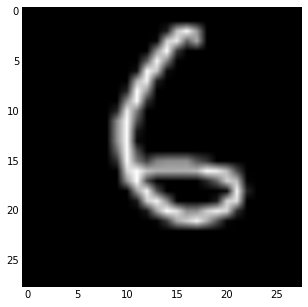

In [44]:
ind = 4546

img = X_train[ind]
acc_label = y_train[ind].argmax()

plt.figure(figsize=(5,5))
plt.imshow(img[:,:,0],cmap="gray")
plt.savefig(path+"base_image"+str(ind)+".png")

print(acc_label)

### For activation specify layer index and no of filters in the layer

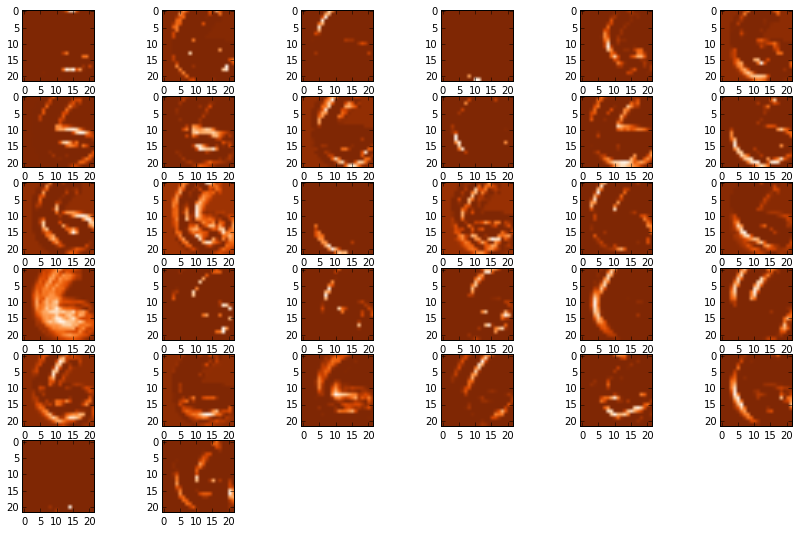

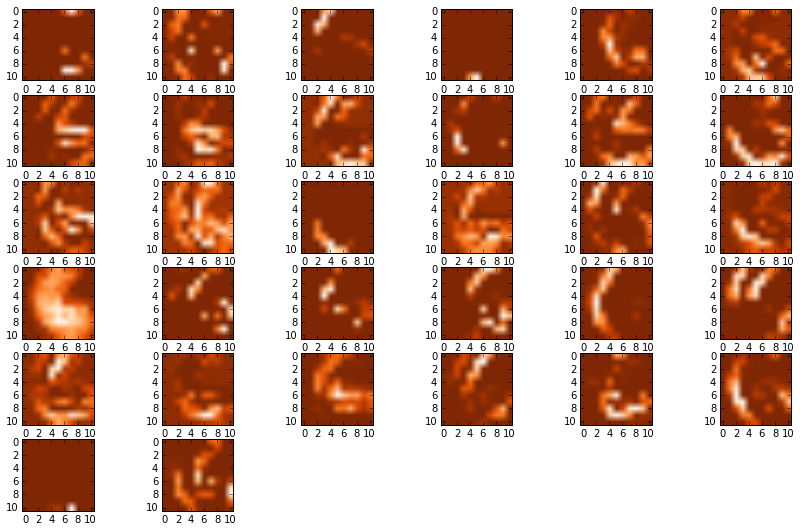

In [46]:
img_row,img_col,channels = img.shape[0],img.shape[1],img.shape[2]
activations = activation(model,img,img_row,img_col,channels)

display_activations(activations,32,1)
display_activations(activations,32,2)

### For filters specify layer name, image size,filters and no of channels in the image

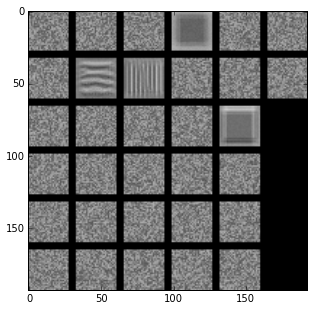

In [47]:
create_output('conv2d_2',28,32,1,True)

### For classs activation specify last conv layer name,actual or predicted class label and no of filters in the conv layer

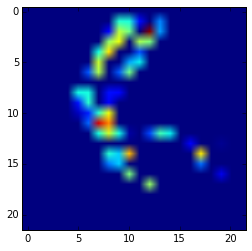

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


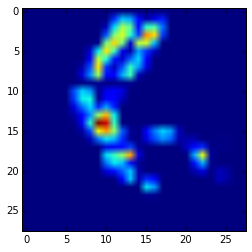

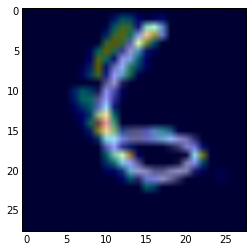

In [45]:
class_activation(img,'conv2d_2',acc_label,32)

## For line 96

6


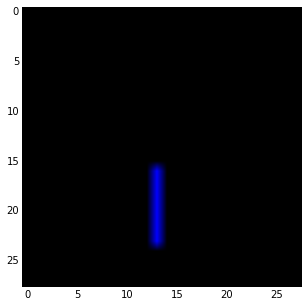

In [26]:
ind = 4534

img = X_train[ind]
acc_label = y_train[ind].argmax()

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.savefig(path+"base_image"+str(ind)+".png")

print(acc_label)

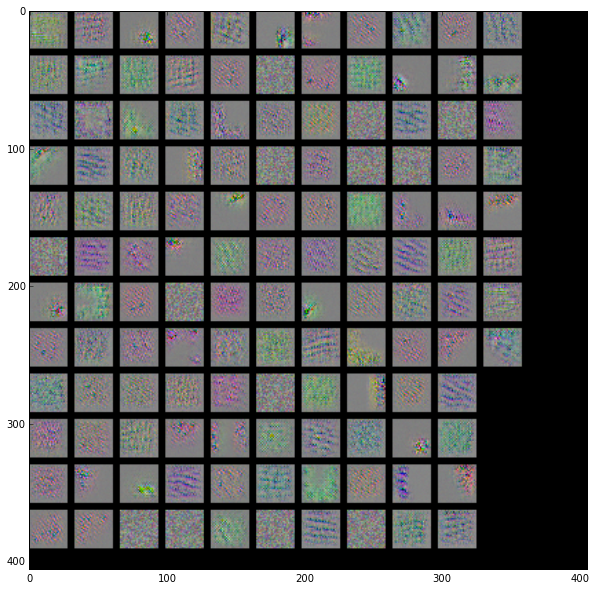

In [32]:
# create_output('conv2d_8',28,32,3,True)
#create_output('conv2d_9',28,64,3,True)
create_output('conv2d_10',28,128,3,True)

In [ ]:
img_row,img_col,channels = img.shape[0],img.shape[1],img.shape[2]
activations = activation(model,img,img_row,img_col,channels)

display_activations(activations,32,1)
display_activations(activations,32,2)
display_activations(activations,64,3)
display_activations(activations,64,4)
display_activations(activations,128,5)

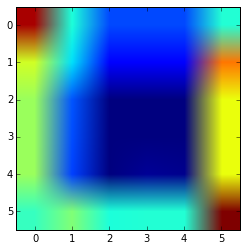

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


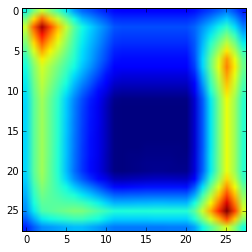

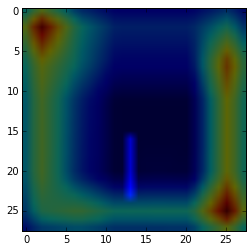

In [27]:
class_activation(img,'conv2d_10',acc_label,128)

#### For Q2
#### Head in order
1. Length
2. Width
3. Color
4. Angle

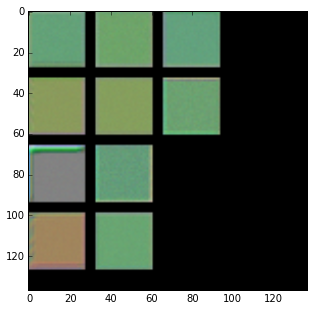

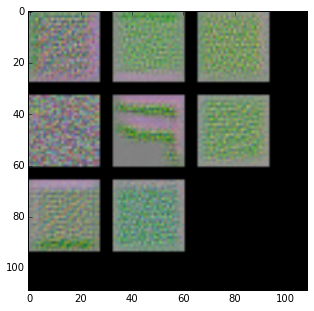

In [22]:
create_output('conv2d_1',28,10,3,True)
create_output('conv2d_2',28,8,3,True)

0 0 0 11


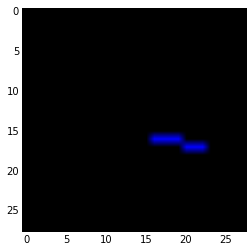

In [57]:
ind = 52445


#### For Q2 #####
img = x_train[ind]
y_l = y_length_train[ind]
y_w = y_width_train[ind]
y_c = y_colour_train[ind]
y_a = y_angle_train[ind].argmax()
print(y_l,y_w,y_c,y_a)


plt.imshow(img)
plt.savefig(path+"base_image"+str(ind)+".png")

### for class activation specify last conv layer name,output value of the head, no of filters in the layer,and if the there are multiple heads(True), and index of that head

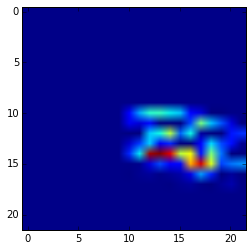

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


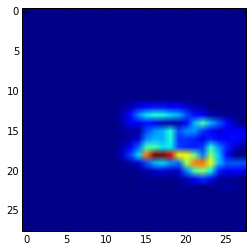

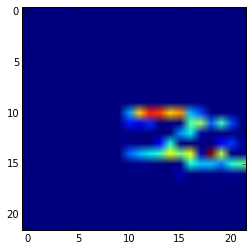

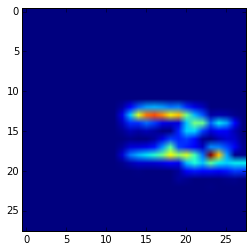

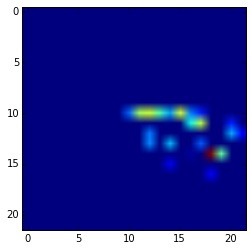

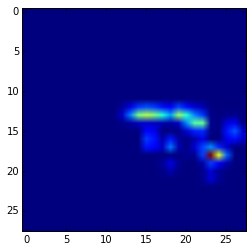

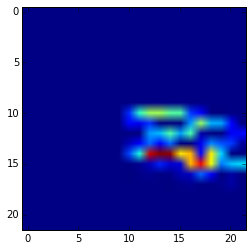

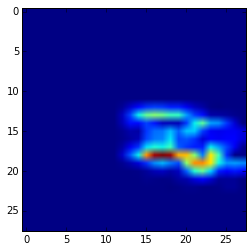

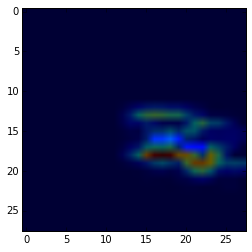

In [119]:
## For Q2
## Head in order

class_activation(img,'conv2d_2',y_l,4,True,0)
class_activation(img,'conv2d_2',y_w,4,True,1)
class_activation(img,'conv2d_2',y_c,4,True,2)
class_activation(img,'conv2d_2',y_a,4,True,3)

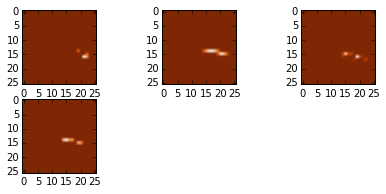

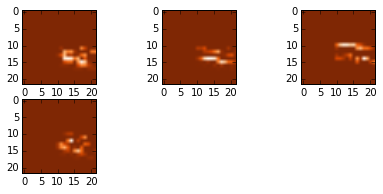

In [58]:
img_row,img_col,channels = img.shape[0],img.shape[1],img.shape[2]
activations = activation(model,img,img_row,img_col,channels)

# display_activations(activations,10,1)
# display_activations(activations,10,2)
# display_activations(activations,8,3)
# display_activations(activations,8,4)

display_activations(activations,4,1)
display_activations(activations,4,2)